<a href="https://colab.research.google.com/github/emilyclifton/cs5262-p2/blob/main/Week9/HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network
### _Emily Clifton_

In [58]:
import numpy as np
import imageio
import sys
import os
import matplotlib.pyplot as plt
import pickle
import random

import gcsfs
!pip install gdown
import gdown

from __future__ import print_function
from random import randrange
from math import sqrt

In [45]:
sys.path.append(os.path.abspath('/content/cs5262-p2/Week9/code'))

from network import Network
from gradient_check import eval_numerical_gradient
from data_utils import load_CIFAR10
from vis_utils import visualize_grid

In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 1: Design Your Neural Network

We use the class `Network` in the file `network.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [15]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return Network(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Forward pass: compute scores
Open the file `network.py` and look at the method `Network.loss`. This function is to take the data and weights and computes the class scores, the loss, and the gradients on the parameters.

First, implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [16]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


### Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [21]:
!ls

cs5262-p2  sample_data


In [33]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.02851791272476567


### Backward pass
In this step, it will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [32]:
# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 1.000000e+00
b2 max relative error: 4.447625e-11
W1 max relative error: 1.000000e+00
b1 max relative error: 2.738421e-09


##Task 2: Network Training
To train the network we will use stochastic gradient descent (SGD). Complete the missing sections in `Network.train` to implement the training procedure.
Then, You will also have to implement `Network.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.015629557257289952


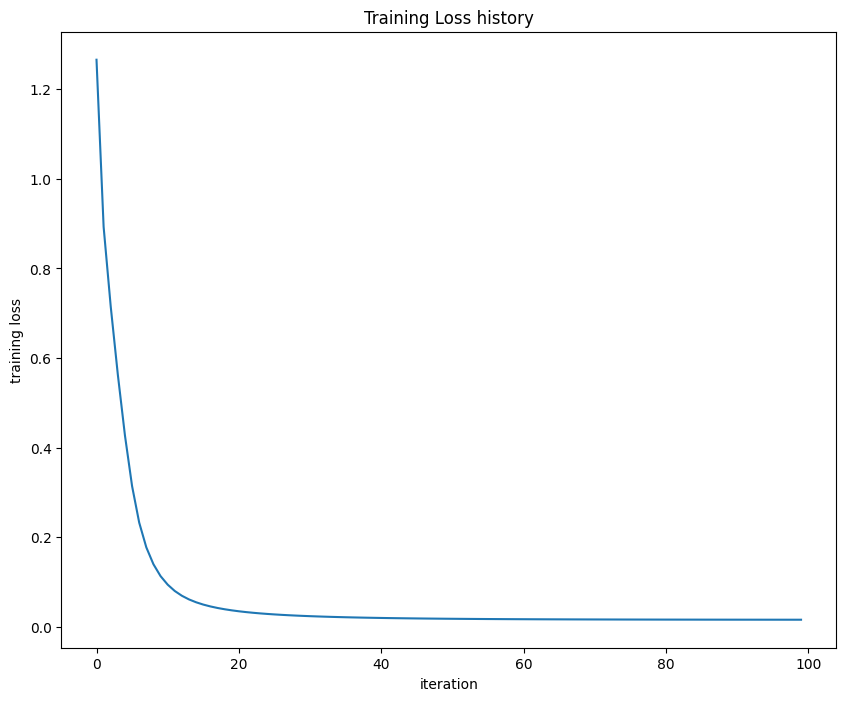

In [36]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

### Load CIFAR-10
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [49]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.abspath('/content/cs5262-p2/Week9/data')

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [64]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = Network(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


iteration 0 / 1000: loss 2.302910
iteration 100 / 1000: loss 2.303191
iteration 200 / 1000: loss 2.305855
iteration 300 / 1000: loss 2.356384
iteration 400 / 1000: loss 2.427878
iteration 500 / 1000: loss 2.457598
iteration 600 / 1000: loss 2.456318
iteration 700 / 1000: loss 2.386205
iteration 800 / 1000: loss 2.315118
iteration 900 / 1000: loss 2.301357
Validation accuracy:  0.281


### Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

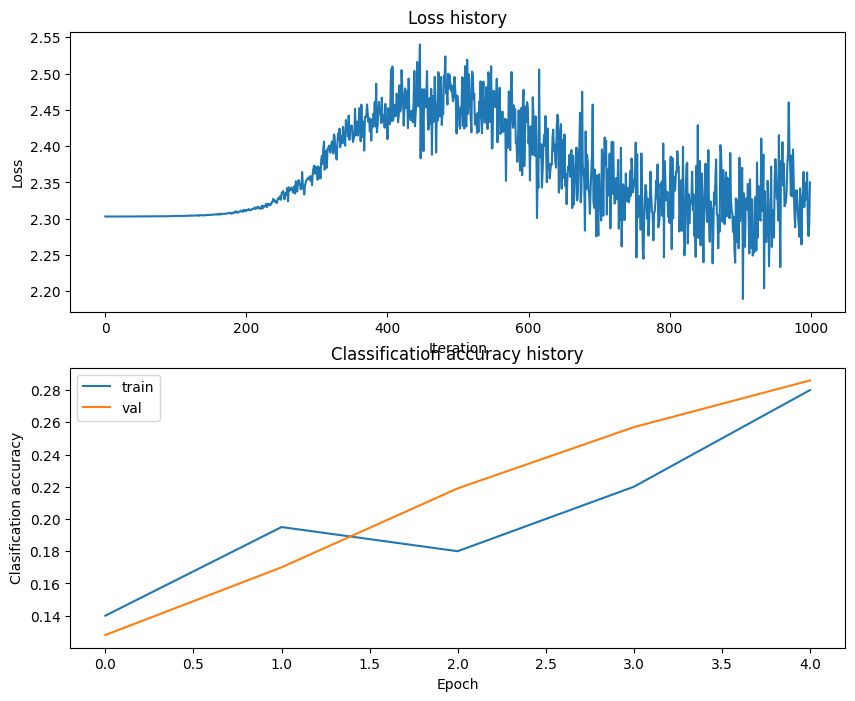

In [51]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

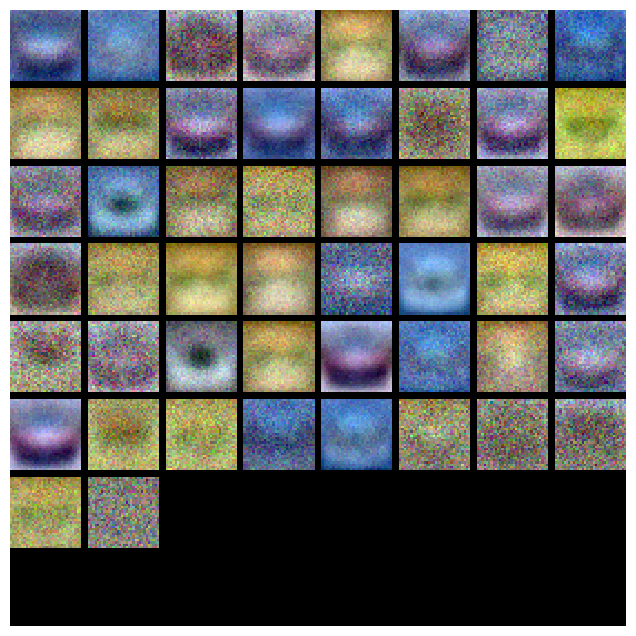

In [53]:
# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

##Task 3: Tune Your Network

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

I Use random search to explore different hyperparameter combinations, evaluating each configuration's performance on the validation set. It iterates a defined number of times, and updates the best configuration based on highest validation accuracy. run_network function creates, trains, and evaluates the neural network with random hyperparametes. After all iterations, it selectss the best performing model and its corresponding hyperparameters.

In [55]:
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################

# Define hyperparameter ranges
hidden_sizes = [50, 100, 200]
num_iters = [1000, 2000]
batch_sizes = [100, 200]
learning_rates = [1e-4, 5e-4, 1e-3]
learning_rate_decays = [0.95]
regs = [0.1, 0.25, 0.5]

best_val_acc = -1
best_hyperparams = None
best_net = None

In [56]:
def run_network(input_size, hidden_size, num_classes, X_train, y_train, X_val, y_val, X_test, y_test,
                num_iter, batch_size, learning_rate, learning_rate_decay, reg):
    # Create and train the network
    net = Network(input_size, hidden_size, num_classes)
    stats = net.train(X_train, y_train, X_val, y_val,
                      num_iters=num_iter, batch_size=batch_size,
                      learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
                      reg=reg, verbose=False)

    # Evaluate on validation set
    val_acc = (net.predict(X_val) == y_val).mean()

    # Evaluate on test set (optional)
    test_acc = (net.predict(X_test) == y_test).mean() if X_test is not None else None

    return stats, val_acc, net, test_acc

In [60]:
# Random search hyperparameters
num_configs = 20  # Number of random configurations to try

for _ in range(num_configs):
    hidden_size = random.choice(hidden_sizes)
    num_iter = random.choice(num_iters)
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    learning_rate_decay = random.choice(learning_rate_decays)
    reg = random.choice(regs)

    stats, val_acc, net, test_acc = run_network(
        input_size, hidden_size, num_classes,
        X_train, y_train, X_val, y_val, X_test, y_test,
        num_iter, batch_size, learning_rate,
        learning_rate_decay, reg)

    print("hs: {}, ni: {}, bs: {}, lr: {:.5f}, lrd: {}, reg: {:.5f}, val: {:.2f}".format(
        hidden_size, num_iter, batch_size, learning_rate, learning_rate_decay, reg, val_acc))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_hyperparams = {
            'hidden_size': hidden_size,
            'num_iter': num_iter,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'learning_rate_decay': learning_rate_decay,
            'reg': reg
        }
        best_net = net

print("Best validation accuracy:", best_val_acc)
print("Best hyperparameters:", best_hyperparams)

hs: 50, ni: 1000, bs: 200, lr: 0.00100, lrd: 0.95, reg: 0.50000, val: 0.47
hs: 50, ni: 1000, bs: 100, lr: 0.00050, lrd: 0.95, reg: 0.10000, val: 0.45
hs: 50, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.25000, val: 0.29
hs: 100, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.10000, val: 0.30
hs: 200, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.50000, val: 0.31
hs: 200, ni: 1000, bs: 200, lr: 0.00050, lrd: 0.95, reg: 0.25000, val: 0.46
hs: 200, ni: 1000, bs: 100, lr: 0.00050, lrd: 0.95, reg: 0.50000, val: 0.44
hs: 50, ni: 1000, bs: 100, lr: 0.00050, lrd: 0.95, reg: 0.25000, val: 0.43
hs: 100, ni: 2000, bs: 100, lr: 0.00100, lrd: 0.95, reg: 0.50000, val: 0.46
hs: 100, ni: 2000, bs: 200, lr: 0.00100, lrd: 0.95, reg: 0.10000, val: 0.51
hs: 100, ni: 1000, bs: 200, lr: 0.00010, lrd: 0.95, reg: 0.25000, val: 0.28
hs: 50, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.25000, val: 0.29
hs: 200, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.10000, val: 0.31
hs: 200, ni: 1000

Here is example output:
```
hs: 50, ni: 1000, bs: 200, lr: 0.00100, lrd: 0.95, reg: 0.50000, val: 0.47
hs: 50, ni: 1000, bs: 100, lr: 0.00050, lrd: 0.95, reg: 0.10000, val: 0.45
hs: 50, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.25000, val: 0.29
hs: 100, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.10000, val: 0.30
hs: 200, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.50000, val: 0.31
hs: 200, ni: 1000, bs: 200, lr: 0.00050, lrd: 0.95, reg: 0.25000, val: 0.46
hs: 200, ni: 1000, bs: 100, lr: 0.00050, lrd: 0.95, reg: 0.50000, val: 0.44
hs: 50, ni: 1000, bs: 100, lr: 0.00050, lrd: 0.95, reg: 0.25000, val: 0.43
hs: 100, ni: 2000, bs: 100, lr: 0.00100, lrd: 0.95, reg: 0.50000, val: 0.46
hs: 100, ni: 2000, bs: 200, lr: 0.00100, lrd: 0.95, reg: 0.10000, val: 0.51
hs: 100, ni: 1000, bs: 200, lr: 0.00010, lrd: 0.95, reg: 0.25000, val: 0.28
hs: 50, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.25000, val: 0.29
hs: 200, ni: 1000, bs: 100, lr: 0.00010, lrd: 0.95, reg: 0.10000, val: 0.31
hs: 200, ni: 1000, bs: 200, lr: 0.00010, lrd: 0.95, reg: 0.50000, val: 0.30
hs: 50, ni: 1000, bs: 200, lr: 0.00100, lrd: 0.95, reg: 0.10000, val: 0.47
hs: 50, ni: 2000, bs: 200, lr: 0.00050, lrd: 0.95, reg: 0.25000, val: 0.49
hs: 50, ni: 1000, bs: 200, lr: 0.00100, lrd: 0.95, reg: 0.10000, val: 0.47
hs: 50, ni: 1000, bs: 200, lr: 0.00100, lrd: 0.95, reg: 0.10000, val: 0.47
hs: 100, ni: 2000, bs: 200, lr: 0.00100, lrd: 0.95, reg: 0.10000, val: 0.49
hs: 100, ni: 1000, bs: 100, lr: 0.00050, lrd: 0.95, reg: 0.50000, val: 0.45
Best validation accuracy: 0.505
Best hyperparameters: {'hidden_size': 100, 'num_iter': 2000, 'batch_size': 200, 'learning_rate': 0.001, 'learning_rate_decay': 0.95, 'reg': 0.1}
```





In [63]:
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

In [72]:
best_net = None # store the best model into this
best_val = -1
best_stats = []
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# Cleaning up variables to prevent loading data multiple times
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

input_size = 32 * 32 * 3
hidden_size = 100
num_classes = 10
best_net = Network(input_size, hidden_size, num_classes)

# Train the best network
best_stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=300,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
best_val = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', best_val)

Clear previously loaded data.
Train data shape: (49000, 3072)
Train labels shape: (49000,)
Validation data shape: (1000, 3072)
Validation labels shape: (1000,)
Test data shape: (1000, 3072)
Test labels shape: (1000,)
iteration 0 / 2000: loss 2.303274
iteration 100 / 2000: loss 2.398500
iteration 200 / 2000: loss 2.119829
iteration 300 / 2000: loss 2.295983
iteration 400 / 2000: loss 2.112713
iteration 500 / 2000: loss 2.017723
iteration 600 / 2000: loss 2.214724
iteration 700 / 2000: loss 2.104626
iteration 800 / 2000: loss 2.147233
iteration 900 / 2000: loss 2.130871
iteration 1000 / 2000: loss 2.213727
iteration 1100 / 2000: loss 2.053128
iteration 1200 / 2000: loss 2.051237
iteration 1300 / 2000: loss 2.176885
iteration 1400 / 2000: loss 2.097822
iteration 1500 / 2000: loss 2.120195
iteration 1600 / 2000: loss 2.109702
iteration 1700 / 2000: loss 1.866950
iteration 1800 / 2000: loss 2.055764
iteration 1900 / 2000: loss 1.935185
Validation accuracy:  0.505


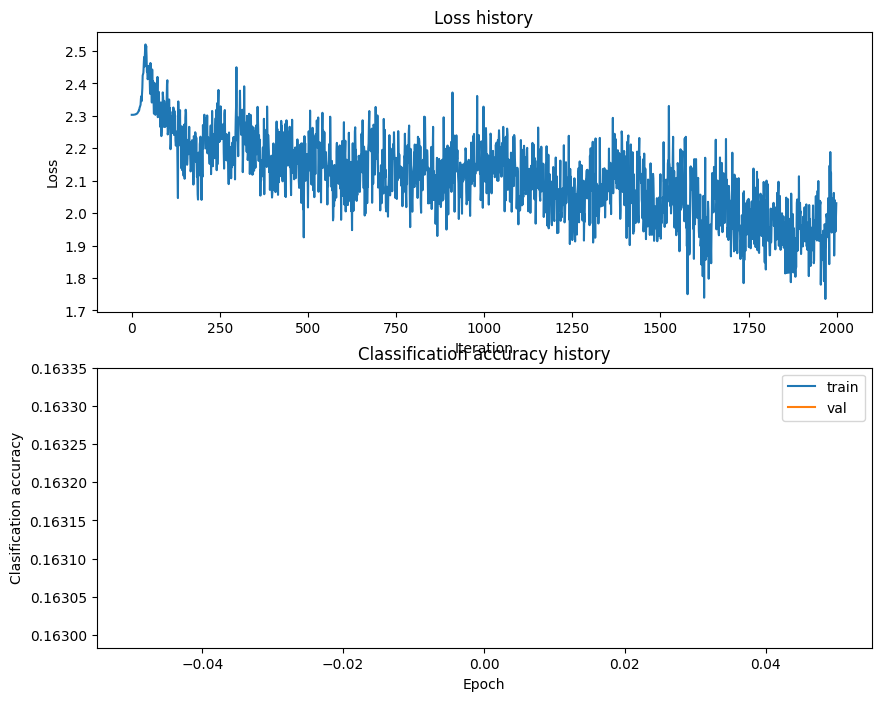

In [73]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

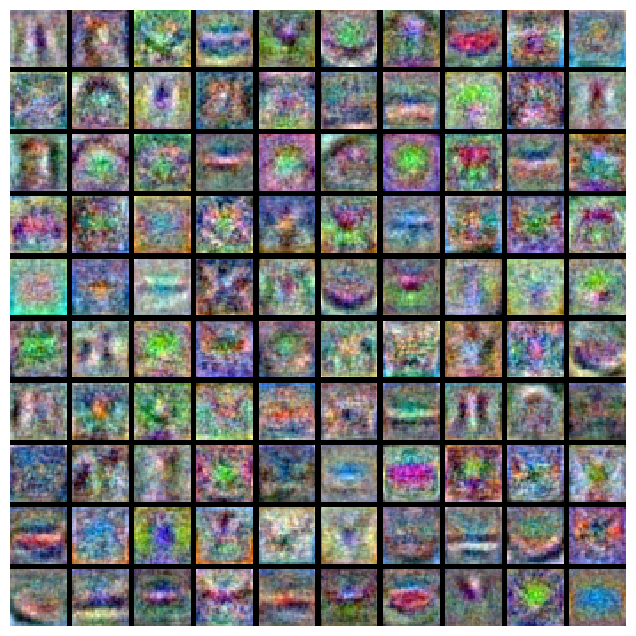

In [74]:
# visualize the weights of the best network
show_net_weights(best_net)

### Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [75]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.509
